# Forecasting Daily Revenue in Havaiianas, ION Orchard Singapore

Notebook prepared by Dominic Dayta for Aroodai and Lean Retail Labs

In [6]:
!pip install statsmodels==0.12.1
!pip install arch
!pip install xlrd==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 13.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
import datetime


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA

from arch import arch_model


# some basic plot parameters
sns.set_style('darkgrid')
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('font', size = 13)

The following notebook makes use of the cleaned sales dashboard data obtained from the ION Orchard store. Data covers information on daily sales, revenue, profits, conversion and other similar retail statistics every day, from Monday, January 1, 2018, to Sunday, July 29 of the same year.

In [13]:
dashboard_df = pd.read_excel (r'/content/drive/MyDrive/Colab Notebooks/Data Science For Retail/Data Files/Cleaned/dashboard.xls')
dashboard_df.drop(dashboard_df.tail(4).index,inplace=True)

dashboard_df.head()

,week_day,date,revenue,units_sold,num_transactions,basket_size,avg_transaction_value,avg_unit_value,total_discount,discount_pct,...,click_collect,online_to_offline_returns,try_non_buy,showroomers,offline_purchase_from_offline_marketing,unnamed_8,price_topseller,compete_price_topseller,compete_num_followers,compete_range_assort
0,Monday,2018-01-01,5668.30,143.0,110.0,1.300000,51.530000,39.638462,100.0,0.017336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tuesday,2018-01-02,2662.10,73.0,61.0,1.196721,43.640984,36.467123,100.0,0.036204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wednesday,2018-01-03,2759.30,74.0,72.0,1.027778,38.323611,37.287838,100.0,0.034974,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Thursday,2018-01-04,1784.24,31.0,38.0,0.815789,46.953684,57.556129,100.0,0.053072,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Friday,2018-01-05,3375.66,72.0,62.0,1.161290,54.446129,46.884167,100.0,0.028772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For testing purposes, we will be hiding the latest record in the data. Our goal is to test if we will be able to "forecast" this hidden value by making use of the remaining records.

In [14]:
test_data = dashboard_df.tail(1)

dashboard_df.drop(dashboard_df.tail(1).index,inplace=True)

## Daily Revenue in Havaianas, ION Orchard

The following line plot shows the recorded daily revenue in the Havaiianas ION Orchard store. We wish to create a model that allows us to take into account this historical revenue and create a forecast that will allow management to plan ahead (i.e., manpower assignment, targets, etc).

One interesting feature we see in this plot is a sudden spike in revenue around May to June of 2018. This period with clsutered spikes usually suggests a conditional heteroskedasticity in the data, which at this point hints at our using a GARCH model for producing the forecast.

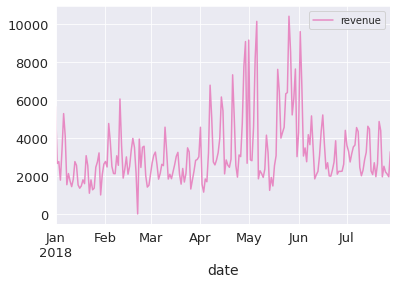

In [15]:
dashboard_df.plot(x = "date", y = "revenue", color = sns.color_palette('Set2')[3])

## Manual Approaches

One common approach which we may consider as statistically simplistic - though not at all invalid - is to simply obtain an average of the most recent data points. For instance, we may instead obtain the average of the last 10 days.

In [18]:
simple_forecast = dashboard_df.tail(10).revenue.mean()
simple_forecast

2792.06

This value is actually quite far from the "correct" value that we hid from the data. The correct revenue value should have been

In [21]:
test_data.revenue

209    4099.7
Name: revenue, dtype: float64

For the purpose of comparison, we can make use of a metric called the Mean Absolute Percentage Error (MAPE), which gives us a value (in percentage) of how far off we are from the correct value. We notice that we are almost 32% too far away from the correct value of the next day revenue.

In [20]:
np.absolute((simple_forecast - test_data.revenue)/test_data.revenue)

209    0.31896
Name: revenue, dtype: float64

Is it possible to design a better forecast for the following day's revenue? Our argument is that the simple averaging method fails to take into account the pattern of daily revenue observed in the data. We will go into more detail regarding this "pattern", but for now we introduce our preferred model of choice for making a better revenue forecast.

## Modeling ARIMA

We come back to the plot we showed earlier. We note that there are periods where revenue experiences large spikes, for instance during May and June 2018. At the same time this is surrounded by periods wherein the fluctuations are much closer to each other. In statistical terms, this periods of low fluctuations follow by brief periods of large spikes is called a "heteroskedasticity".

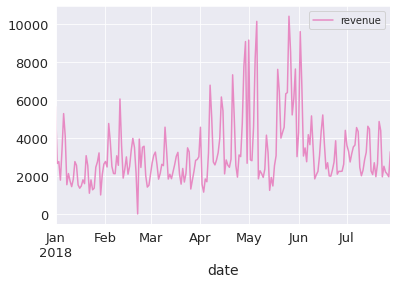

In [22]:
dashboard_df.plot(x = "date", y = "revenue", color = sns.color_palette('Set2')[3])

The averaging method ignores these heteroskedasticities and assumes that variances are uniform throughout all the periods being averaged. In contrast, a GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model will be able to take into account this behavior of the variances.

Prior to creating the GARCH model, we first create an ARIMA (Autoregressive Integrated Moving Average) model to account for the progression of the average daily revenue. The ARIMA model has two key components: autoregression (meaning that the expected revenue depends on expected revenue from the previous days) and the moving average model (meaning that fluctuations or error terms are correlated with error terms from the previous days).

To identify the level of autoregression and autocorrelation, we look into the autocorrelation and partial autocorrelation plots.

In [23]:
dashboard2 = dashboard_df[["revenue","date"]].dropna()
series = dashboard2["revenue"]

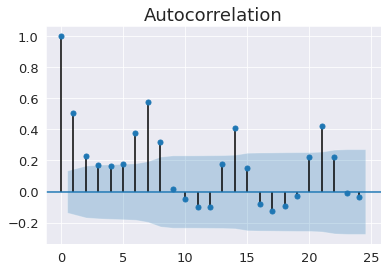

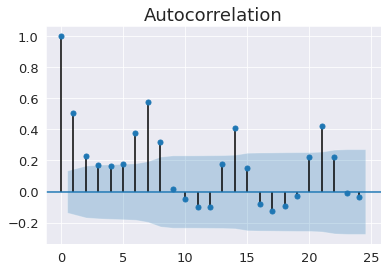

In [24]:
plot_acf(series)

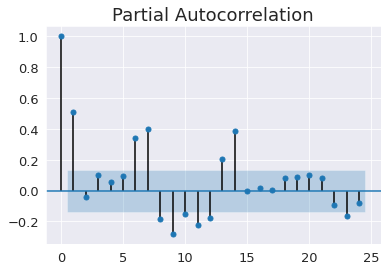

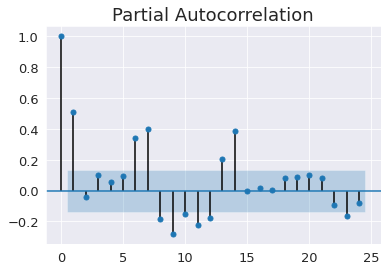

In [25]:
plot_pacf(series)

Significant spikes in the first period with significant correlation in the ACF/PACF plots suggest either an AR(1) or an MA(1) model. We model first the MA(1) model and see the resulting fit.

In [55]:
arima_model = ARIMA(series, order = (0,0,2))
arima_fit = arima_model.fit()

In [56]:
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                  209
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -1829.316
Date:                Wed, 03 Aug 2022   AIC                           3666.632
Time:                        16:02:32   BIC                           3680.002
Sample:                             0   HQIC                          3672.038
                                - 209                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3248.4354    263.861     12.311      0.000    2731.277    3765.594
ma.L1          0.5426      0.052     10.447      0.000       0.441       0.644
ma.L2          0.1550      0.064      2.431      0.0

The above model suggests that there is a significant autocorrelation in the error terms that must be taken into account. The revenue at time $t$ can be expressed as

$$
rev_t = 3248.4354 + \varepsilon_t + 0.5426 \varepsilon_{t-1}  + 0.1550 \varepsilon_{t-1}
$$

This means that on average, revenue tends to fluctuate around an average of 3248.4354 per day, adjusted by 0.5426 for each 1 unit fluctuation from the previous time period ($\varepsilon_{t-1}$), and 0.1550 from the time period after that ($\varepsilon_{t-2}$). Other AR or MA terms may be needed for this model, and to check for this, we look into the resulting ACF/PACF plot of the residual series $\varepsilon_t$.

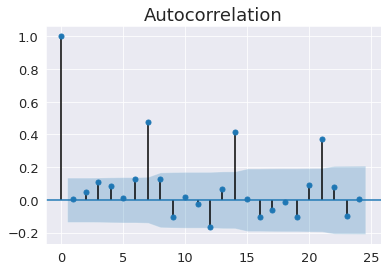

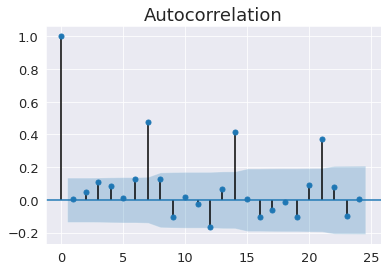

In [57]:
arima_resid = arima_fit.resid

plot_acf(arima_resid)

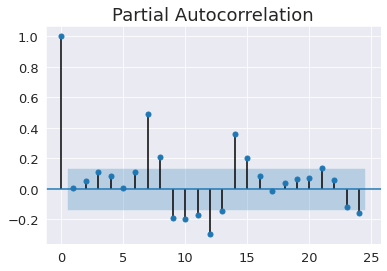

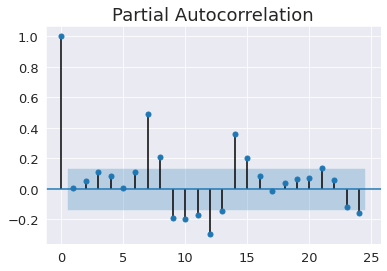

In [58]:
plot_pacf(arima_resid)

We see more spikes in further time periods (around 8 to 9) but we concede that this is going to be very far fom what might reasonably impact revenue (adding an MA or AR term at 9 lags suggests that the next day revenue is potentially affected by the last 9 days of revenue). We ignore this in favor of a simpler ARMA structure as we will now accommodate the GARCH component.

Using the Weighted ARCH test by Engle, we see that there is significant heteroskedasticity in the resulting error term. This motivates our use of the GARCH model.

In [59]:
het_arch(arima_resid) # returns LM stat, p-val, F stat, and p value

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:660: FutureWarning: The default value of nlags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setmaxlags or period to silence this warning.
  FutureWarning)


(43.94662307163775,
 0.00011209981134764948,
 3.47542946244882,
 3.2434329096946975e-05)

The Weighted Ljung-Box test also suggests the possibility of continuing serial correlation, but once more we will return to this later after seeing the result of accounting for the GARCH errors.

In [60]:
sm.stats.acorr_ljungbox(arima_resid)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:533: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([4.17286650e-03, 5.30904529e-01, 3.14193245e+00, 4.69627925e+00,
        4.72900813e+00, 8.25077962e+00, 5.77913908e+01, 6.13131277e+01,
        6.36113969e+01, 6.36564606e+01, 6.38088574e+01, 7.00960616e+01,
        7.10086745e+01, 1.09790333e+02, 1.09793731e+02, 1.12277043e+02,
        1.13103066e+02, 1.13158418e+02, 1.15662149e+02, 1.17491883e+02,
        1.49821850e+02, 1.51381144e+02, 1.53620190e+02, 1.53630862e+02,
        1.53854884e+02, 1.60716727e+02, 1.65093905e+02, 1.98703526e+02,
        2.00725153e+02, 2.03062978e+02, 2.03826212e+02, 2.03831772e+02,
        2.06206429e+02, 2.06606621e+02, 2.41228586e+02, 2.41228616e+02,
        2.43014952e+02, 2.43239002e+02, 2.43321426e+02, 2.47510566e+02]),
 array([9.48494293e-01, 7.66859048e-01, 3.70255420e-01, 3.19903859e-01,
        4.49839103e-01, 2.20300292e-01, 4.16029838e-10, 2.57388424e-10,
        2.68506831e-10, 7.31924108e-10, 1.80378580e-09, 3.07316009e-10,
        5.23151762e-10, 6.14370678e-17, 1.76644312e-16, 1.6534

## Modeling Heteroskedasticity Using GARCH

Within the GARCH model, we are separately modeling the error term to account for a conditional variance $\sigma_t$ in the error terms that's varying in time rather than fixed throughout the data coverage. The error term $\varepsilon_t$ can be written as

$$
\varepsilon_t = \sigma_t w_t
$$

Which accounts for the heteroskedasticities in the model. Typically a GARCH(1,1) model is sufficient for most data, and we test that below.

In [61]:
garch_model = arch_model(arima_resid, vol = "GARCH", p = 1, q = 1, rescale = False)
garch_fit = garch_model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3017.5952727973163
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1806.814079011038
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1805.932391837059
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1805.0077582427612
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1805.00714475718
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1805.0033450001151
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1804.994813867144
Iteration:      8,   Func. Count:     46,   Neg. LLF: 1804.971639943124
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1804.915746522439
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1804.784873611742
Iteration:     11,   Func. Count:     61,   Neg. LLF: 1804.5262048861214
Iteration:     12,   Func. Count:     66,   Neg. LLF: 1804.1287675561562
Iteration:     13,   Func. Count:     71,   Neg. LLF: 1803.6481681455816
Iteration:     14,   Func. Count:     76,   Neg. LLF: 1803.

In [62]:
print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1803.03
Distribution:                  Normal   AIC:                           3614.05
Method:            Maximum Likelihood   BIC:                           3627.42
                                        No. Observations:                  209
Date:                Wed, Aug 03 2022   Df Residuals:                      208
Time:                        16:04:24   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu          -167.8722     94.925     -1.768  7.698e-02 [-3.53

We are fitting this on the error term of the ARIMA model we just showed. This means that the fluctuation in $\varepsilon_t$ contains a further adjustment in mean,

$$
\varepsilon_t = -167.8722 + \sigma_t w_t
$$

Where the conditional variance $\sigma_t$ is modeled further as

$$
\sigma^2_t = 0.00046907 + 0.1159 \varepsilon^2_t + 0.8667 \sigma^2_t
$$

Because this already accounts for the heteroskedasticity in the ARIMA errors obtained earlier, the GARCH error $w_t$ should already be free of heteroskedasticity. We test this again using the Weighted ARCH test, which no longer returns a significant result.

In [63]:
garch_fit.arch_lm_test(lags = 1, standardized = True)

ARCH-LM Test
H0: Standardized residuals are homoskedastic.
ARCH-LM Test
H1: Standardized residuals are conditionally heteroskedastic.
Statistic: 0.0050
P-value: 0.9435
Distributed: chi2(1)
WaldTestStatistic, id: 0x7fd92e0c14d0

Likewise, the Weighted Ljung-Box test no longer returns significant p-values for any of the lags (except for lags 7 and 8, which we consider too far in time to be meaningful).

In [64]:
garch_resid = garch_fit.resid
sm.stats.acorr_ljungbox(garch_resid)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:533: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([4.17286650e-03, 5.30904529e-01, 3.14193245e+00, 4.69627925e+00,
        4.72900813e+00, 8.25077962e+00, 5.77913908e+01, 6.13131277e+01,
        6.36113969e+01, 6.36564606e+01, 6.38088574e+01, 7.00960616e+01,
        7.10086745e+01, 1.09790333e+02, 1.09793731e+02, 1.12277043e+02,
        1.13103066e+02, 1.13158418e+02, 1.15662149e+02, 1.17491883e+02,
        1.49821850e+02, 1.51381144e+02, 1.53620190e+02, 1.53630862e+02,
        1.53854884e+02, 1.60716727e+02, 1.65093905e+02, 1.98703526e+02,
        2.00725153e+02, 2.03062978e+02, 2.03826212e+02, 2.03831772e+02,
        2.06206429e+02, 2.06606621e+02, 2.41228586e+02, 2.41228616e+02,
        2.43014952e+02, 2.43239002e+02, 2.43321426e+02, 2.47510566e+02]),
 array([9.48494293e-01, 7.66859048e-01, 3.70255420e-01, 3.19903859e-01,
        4.49839103e-01, 2.20300292e-01, 4.16029838e-10, 2.57388424e-10,
        2.68506831e-10, 7.31924108e-10, 1.80378580e-09, 3.07316009e-10,
        5.23151762e-10, 6.14370678e-17, 1.76644312e-16, 1.6534

The spike in the ACF/PACF plot for time period 2 that we saw also after modeling ARIMA no longer appears in the ACF/PACF plot after GARCH.

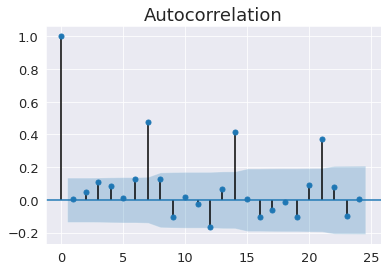

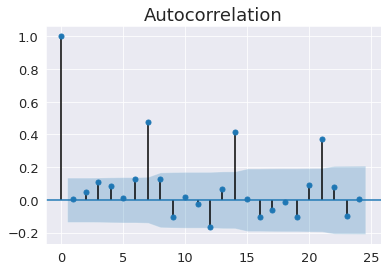

In [65]:
plot_acf(garch_resid)

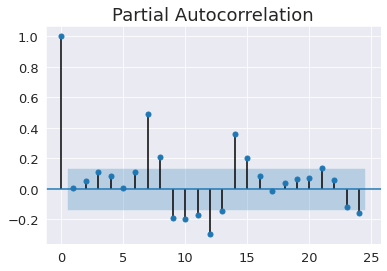

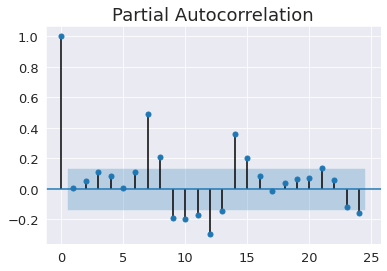

In [66]:
plot_pacf(garch_resid)

## Forecasting Future Revenue

Now that we have a working model for the daily revenue, we can finally produce the forecast. We will forecast the expected revenue for the next day. First we forecast the average returns for the ARIMA model.

In [67]:
arima_fit.forecast(1)

209    3435.909292
dtype: float64

After the ARIMA forecast, we also forecast the error terms through the GARCH model.

In [68]:
garch_forecast = garch_fit.forecast(horizon = 1, reindex = False)
garch_forecast.mean

,h.1
208,-167.872193


The ARIMA terms plus the GARCH errors produces our forecast for the next ten days. From this forecast we can see that we are expecting a revenue of 3,348.88 SGD on the first day after the last record in the data, which is for June 30. After that, for the next nine days we are expecting revenue of about 3,057.66 SGD, but again this will have to be adjusted given the autocorrelated nature of revenue as observed through the ARIMA and GARCH models.

In [69]:
garch_et = pd.DataFrame(garch_forecast.mean).transpose().reset_index().iloc[:,1]

arima_forecast = arima_fit.forecast(1)
arima_mean = arima_forecast.reset_index().iloc[:,1]

garch_forecast = arima_mean + garch_et
garch_forecast

0    3268.037099
dtype: float64

We note that this is definitely much closer to our original forecast from before. We can look into the MAPE as well. MAPE for the simple averaging method was 32%. For the ARIMA-GARCH Model, this is:

In [70]:
np.absolute((garch_forecast - test_data.revenue.reset_index().iloc[:,1])/test_data.revenue.reset_index().iloc[:,1])

0    0.202859
dtype: float64

Our MAPE is now 20%. We have been able to reduce our error from 32% down by 12% with a simple model. Proper tuning of the model and more data to use in production would allow us to further shave that off and obtain even more accurate results. We can see therefore how this approach will be quite beneficial for improving our estimate of revenue. With this improved knowledge of our expected future revenue, we can plan ahead with much better accuracy other parameters of operations, including manpower costing and perhaps intraday strategies, to help optimize profit.